# Tiger County and State Boundaries

Tiger County and State Boundaries

This notbook show examples of reading geographic partitions, plotting the data as a map, and linking the geographies to other datasets. 

## Setup 

We'll start with some basic setup, loading matplotlib, Ambry and getting the Ambry library. 


In [1]:
import warnings; 
warnings.simplefilter("ignore") # Ignore warnings from matplotlib's font cache
%matplotlib inline 
import matplotlib.pyplot as plt

from ambry import get_library
l = get_library()

Next, we can get two of the Tiger line partitions. If these partitions aren't local, they wil be downloaded, which may take a while. 

In [2]:
states_p = l.partition('census.gov-tiger-statecounty-2015-states')
counties_p = l.partition('census.gov-tiger-statecounty-2015-counties')

## Creating Geodataframes

We can use the ``Partition.geoframe()`` method to get a Geopandas GeoDataFrame for the partition data. The GeoDataFrame work like a Pandas DataFrame, but it holds ``geometry`` column in a GeoSeries, which understands and manipulates gegraphic data. 

The Tiger data for use US states has entries for non-contiguous states and territories, some of which are in the south pacific. We'll need to remove them to prevent the map from covering  the entire earth. The ``geoframe()`` method also also alows for simplifying the geometries, by reducing the number of points. The ``simplify`` argument is the tolerance for the reduced geometry, in the units of the geometry, which is degrees in this case. 


In [3]:
non_contig = ('AK','HI','PR','VI','GU', 'AS', 'MP') # USPS postal codes for non-contiguous states and territories

states_df = states_p.geoframe(simplify=0.1, predicate=lambda row: row.stusps not in non_contig)


## Plot

The GeoDataFrame has a ``plot()`` method for producing a plot of the geometries in the dataframe. 


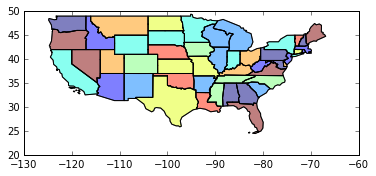

In [4]:
states_df.plot()

The ``plot()`` method doesn't allow for much customization, but you can alter the figure, using matplotlib configuration, and the ``column`` argument will set the column to use for a value to determine the color of each shape. 

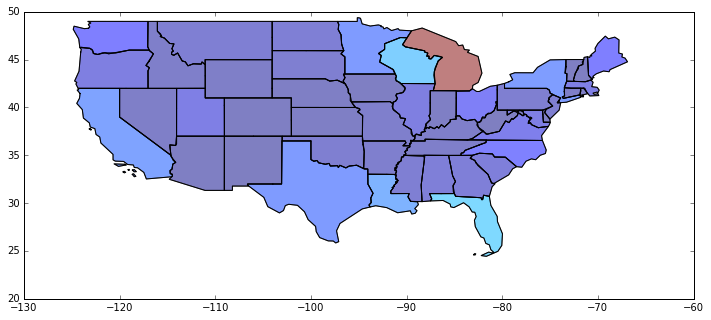

In [5]:
# Make the plot larger, and color the states by the area of water in teh state.
plt.figure(figsize=(12,6))
states_df.plot(column='awater')

# Merging with other data

All ambry datasets that have geometry or can be linked to geometry have a ``gvid`` colum, which holds a proprietary version of the US Census geoids. You can join dataframe on these values to link them together. 


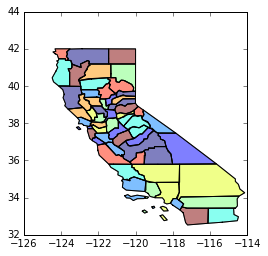

In [6]:
# Load the counties in California
counties_df = counties_p.geoframe(simplify=0.05, predicate=lambda row: row.statefp == 6)
counties_df.plot()

We'll link these counties to a dataset from the [Healthy Communities Indicators. ](http://main.data.civicknowledge.com/bundles/d04p.html). This one reports the percentage of resident within 1/2 mile of a park. 

In [7]:
openspc_df = l.partition('cdph.ca.gov-hci-open_space-county').dataframe()

In [8]:
openspc_all = openspc_df[ (openspc_df.race_eth_name == 'Total')][['gvid','p_parkacc','pop2010', 'pop_park_acc'] ]
openspc_all.head()

,gvid,p_parkacc,pop2010,pop_park_acc
464,0O0601,0.919045,1510271,1388007
465,0O0603,0.920000,1175,1081
466,0O0605,0.334095,38091,12726
467,0O0607,0.623141,220000,137091
468,0O0609,0.357870,45578,16311


To join the datasets, set the `gvid` column to be the index in both of them, when use `join()`.

In [9]:
count_parks = counties_df.set_index('gvid').join(openspc_all.set_index('gvid'))

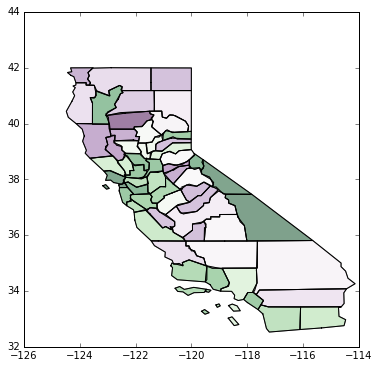

In [10]:
# Plot percentage of population with access to parks. Purple is low and green is high. 
plt.figure(figsize=(6, 12))
count_parks.plot(column='p_parkacc', colormap='PRGn')

# Using Matplotlib Basemap

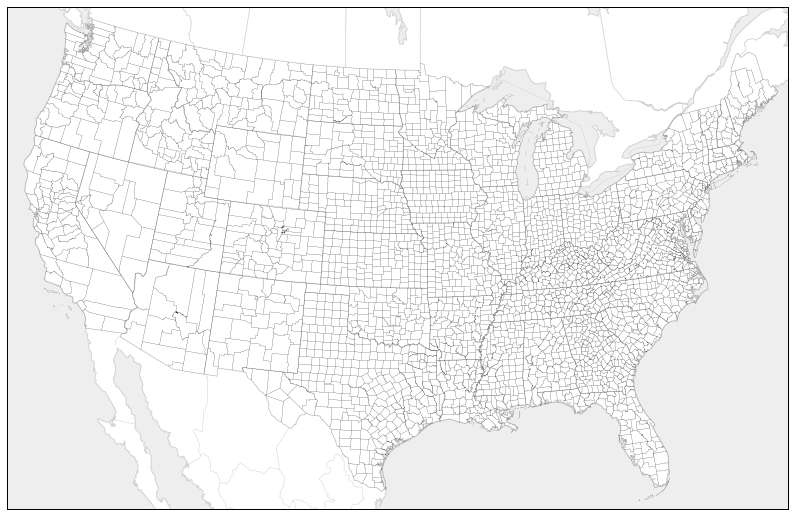

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(14, 10))
m = Basemap(projection='lcc', # Lambert conformal projection
               resolution='l', # # Low resolution boundary lines
               # Extents of the map, in lat/lon
               llcrnrlon=-119, urcrnrlon=-64, llcrnrlat=22, urcrnrlat=49, 
               # Standard parallels; parameters of the projection
               lat_1=33, lat_2=45, 
               # Central point
               lon_0=-95,
               area_thresh=10000 # DOn't plot features with area smaller than this
           )

# Draw map background
m.fillcontinents(color='white', lake_color='#eeeeee')
m.drawstates(color='lightgray')
m.drawcoastlines(color='lightgray')
m.drawcountries(color='lightgray')
m.drawmapboundary(fill_color='#eeeeee')
m.drawcounties()


In [39]:
from shapely.wkt import loads

ca = next(row for row in states_p if row.stusps == 'CA')
geo = loads(ca.geometry)

geo.bounds #(minx, miny, maxx, maxy) -> (llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat)

plt.figure(figsize=(9, 12))
m = Basemap(projection='lcc', # Lambert conformal projection
               resolution='l', # # Low resolution boundary lines
               # Extents of the map, in lat/lon
               llcrnrlon=-119, urcrnrlon=-64, llcrnrlat=22, urcrnrlat=49, 
               # Standard parallels; parameters of the projection
               lat_1=33, lat_2=45, 
               # Central point
               lon_0=-95,
               area_thresh=10000 # DOn't plot features with area smaller than this
           )



(-124.48200299999999, 32.528832, -114.131211, 42.009516999999995)


# Adding shapes to a basemap

You can add shapes to a basemap as matplotlib patches. The `Partition.patches()` method will convert a partition to a list of patches, which can be added to the figure.  


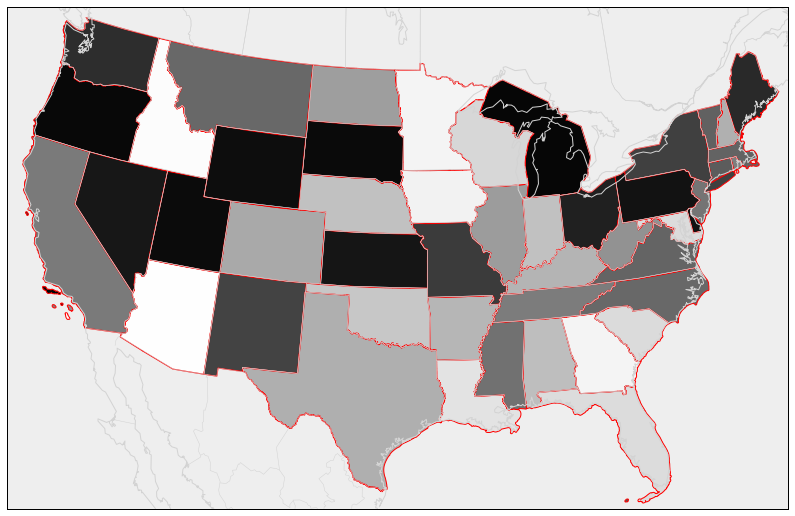

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

# create the map
plt.figure(figsize=(14, 10))
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
       projection='lcc',lat_1=33,lat_2=45,lon_0=-95,
       area_thresh=10000, resolution='l')


#m.fillcontinents(color='white', lake_color='#eeeeee')
m.drawstates(color='lightgray')
m.drawcoastlines(color='lightgray')
m.drawcountries(color='lightgray')
m.drawmapboundary(fill_color='#eeeeee')

# Function to set  properties of each patch. 
def patch_args(row):
    import random
    return {
        'gid': row.gvid,
        'label': row.stusps,
        'facecolor': str(random.random()), # Gray scale
        'edgecolor': 'red', 
        'hatch': 'xx'
    }


# Create the patches. Must pass in the basemap so it can transform coordinates. 
patches = states_p.patches(m, args_f = patch_args)

ax = plt.gca() # get current axes instance

# Add the patches. 
ax.add_collection(PatchCollection(patches, match_original=True))

plt.show()
